# Предобработка данных

## Импорт библиотек

In [16]:
import pandas as pd
import cv2
import os
import numpy as np

from PIL import Image as PILImage

from pytesseract import Output
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract.exe'
tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract.exe'
import pyocr
pyocr.tesseract.TESSERACT_CMD = r'C:/Program Files/Tesseract-OCR/tesseract.exe'
#cmd_tess = r'C:/Program Files/Tesseract-OCR/tesseract.exe'

from IPython.display import display_html
from openpyxl import load_workbook
from io import BytesIO

from img2table.document import Image
from img2table.ocr import TesseractOCR
#from img2table.ocr import EasyOCR

## Загрузка и осмотр данных

In [2]:
shape_counter = 0
nan_counter = 0
columns = 10
df_list = []

for filename in os.listdir('405/'):
    if 'csv' in filename:
        path = '405/' + filename
        df = pd.read_csv(path)
        print('\n', filename)
        print(df.head())
        df_list.append(df)
        if df.shape[1] != columns:
            shape_counter += 1
        if df.isna().sum().sum() != 0:
            nan_counter += 1
print('\n', 'Число файлов где количество столбцов отличается от 10---', shape_counter)
print('\n', 'Число файлов с пропусками---', nan_counter)


 141899.csv
       ID  ID пользователя    Класс крови Дата донации  \
0   87330           141899  Цельная кровь   21.06.2019   
1  213527           141899         Плазма   29.08.2019   
2  213528           141899         Плазма   30.09.2019   
3  213529           141899         Плазма   01.11.2019   
4  213530           141899         Плазма   02.12.2019   

  Дата добавления донации   Тип донации                          Регион  \
0              18.11.2020  Безвозмездно  Россия, Татарстан, Альметьевск   
1              16.05.2023  Безвозмездно  Россия, Татарстан, Альметьевск   
2              16.05.2023  Безвозмездно  Россия, Татарстан, Альметьевск   
3              16.05.2023  Безвозмездно  Россия, Татарстан, Альметьевск   
4              16.05.2023  Безвозмездно  Россия, Татарстан, Альметьевск   

   Место стадчи Статус донации Есть справка  
0           703        Принята           Да  
1           703        Принята           Да  
2           703        Принята           Да  
3  

**Чтож, неплохо. все таблицы имеют одинаковое число столбцов, пропусков нет. Жить можно**

## Добавляем город и убираем лишние столбцы

In [3]:
def region_to_city(st):
    return st.split(', ')[-1]

In [4]:
trash_columns = ['ID', 'ID пользователя', 'Дата добавления донации', 'Место стадчи', 'Статус донации', 'Есть справка', 'Регион']

for i in range(len(df_list)):
    df_list[i]['Город'] = df_list[i]['Регион'].apply(region_to_city)
    df_list[i] = df_list[i].drop(trash_columns, axis=1)

In [5]:
df_list[5].head()

,Класс крови,Дата донации,Тип донации,Город
0,Цельная кровь,03.07.2009,Безвозмездно,Ульяновск
1,Цельная кровь,16.09.2009,Безвозмездно,Ульяновск
2,Цельная кровь,16.03.2011,Безвозмездно,Ульяновск
3,Цельная кровь,01.08.2011,Безвозмездно,Ульяновск
4,Цельная кровь,24.11.2011,Безвозмездно,Ульяновск


## Функции для работы

### Препроцессинг

**Обрезка** В первом приближении - обрезаем пополам. Потому что у справки формы 405 таблица всегда в нижней половине.

**Оттенки серого**

**Удаление шумов**

**Приведение к пороговому значению** Gaussian

In [6]:
def pre(img):
    height = int(img.shape[0])
    half = int(img.shape[0] / 2)
    cut = img[half:height, :]
    gray = cv2.cvtColor(cut, cv2.COLOR_BGR2GRAY)
    noise = cv2.medianBlur(gray,1)
    thresh = cv2.adaptiveThreshold(noise,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,11)
    out = thresh
    return out

#ret,thresh3 = cv.threshold(img,127,255,cv.THRESH_TRUNC)
#ret,thresh4 = cv.threshold(img,127,255,cv.THRESH_TOZERO)

### Поиск слов при помощи tesseract

In [18]:
def tess_boxes(img):
    d = pytesseract.image_to_data(img, output_type=Output.DICT)
    n_boxes = len(d['text'])
    for i in range(n_boxes):
        if int(d['conf'][i]) > 60:
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            return cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

### Поиск контуров определенного размера при помощи open cv

In [27]:
def cont(img):
    contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    img_contours = np.uint8(np.zeros((img.shape[0],img.shape[1])))
    #all_contours = cv2.drawContours(img_contours, contours, -1, (255,255,255), 1)
    cell = []
    for contour in contours:
        if contour.shape[0] > 50:
            cell.append(contour)
    return cv2.drawContours(img_contours, cell, 0, (255,255,255), 1)
#cl = np.array(cell).reshape((-1,1,2)).astype(np.int32)

# Первые попытки что-то распознать

## OPEN CV + Tesseract

**Взято плохое изображение и изображение среднего качества**

In [7]:
bad = cv2.imread('405/141899 .jpg')
good = cv2.imread('405/245365 .jpg')
good_pre = pre(good)
bad_pre = pre(bad)

cv2.imwrite('good.png', good_pre)
cv2.imwrite('bad.png', bad_pre)

cv2.imshow('good after', good_pre)
cv2.imshow('good before', good)
cv2.imshow('bad after', bad_pre)
cv2.imshow('bad before', bad)

cv2.waitKey()
cv2.destroyAllWindows()

## Img2table

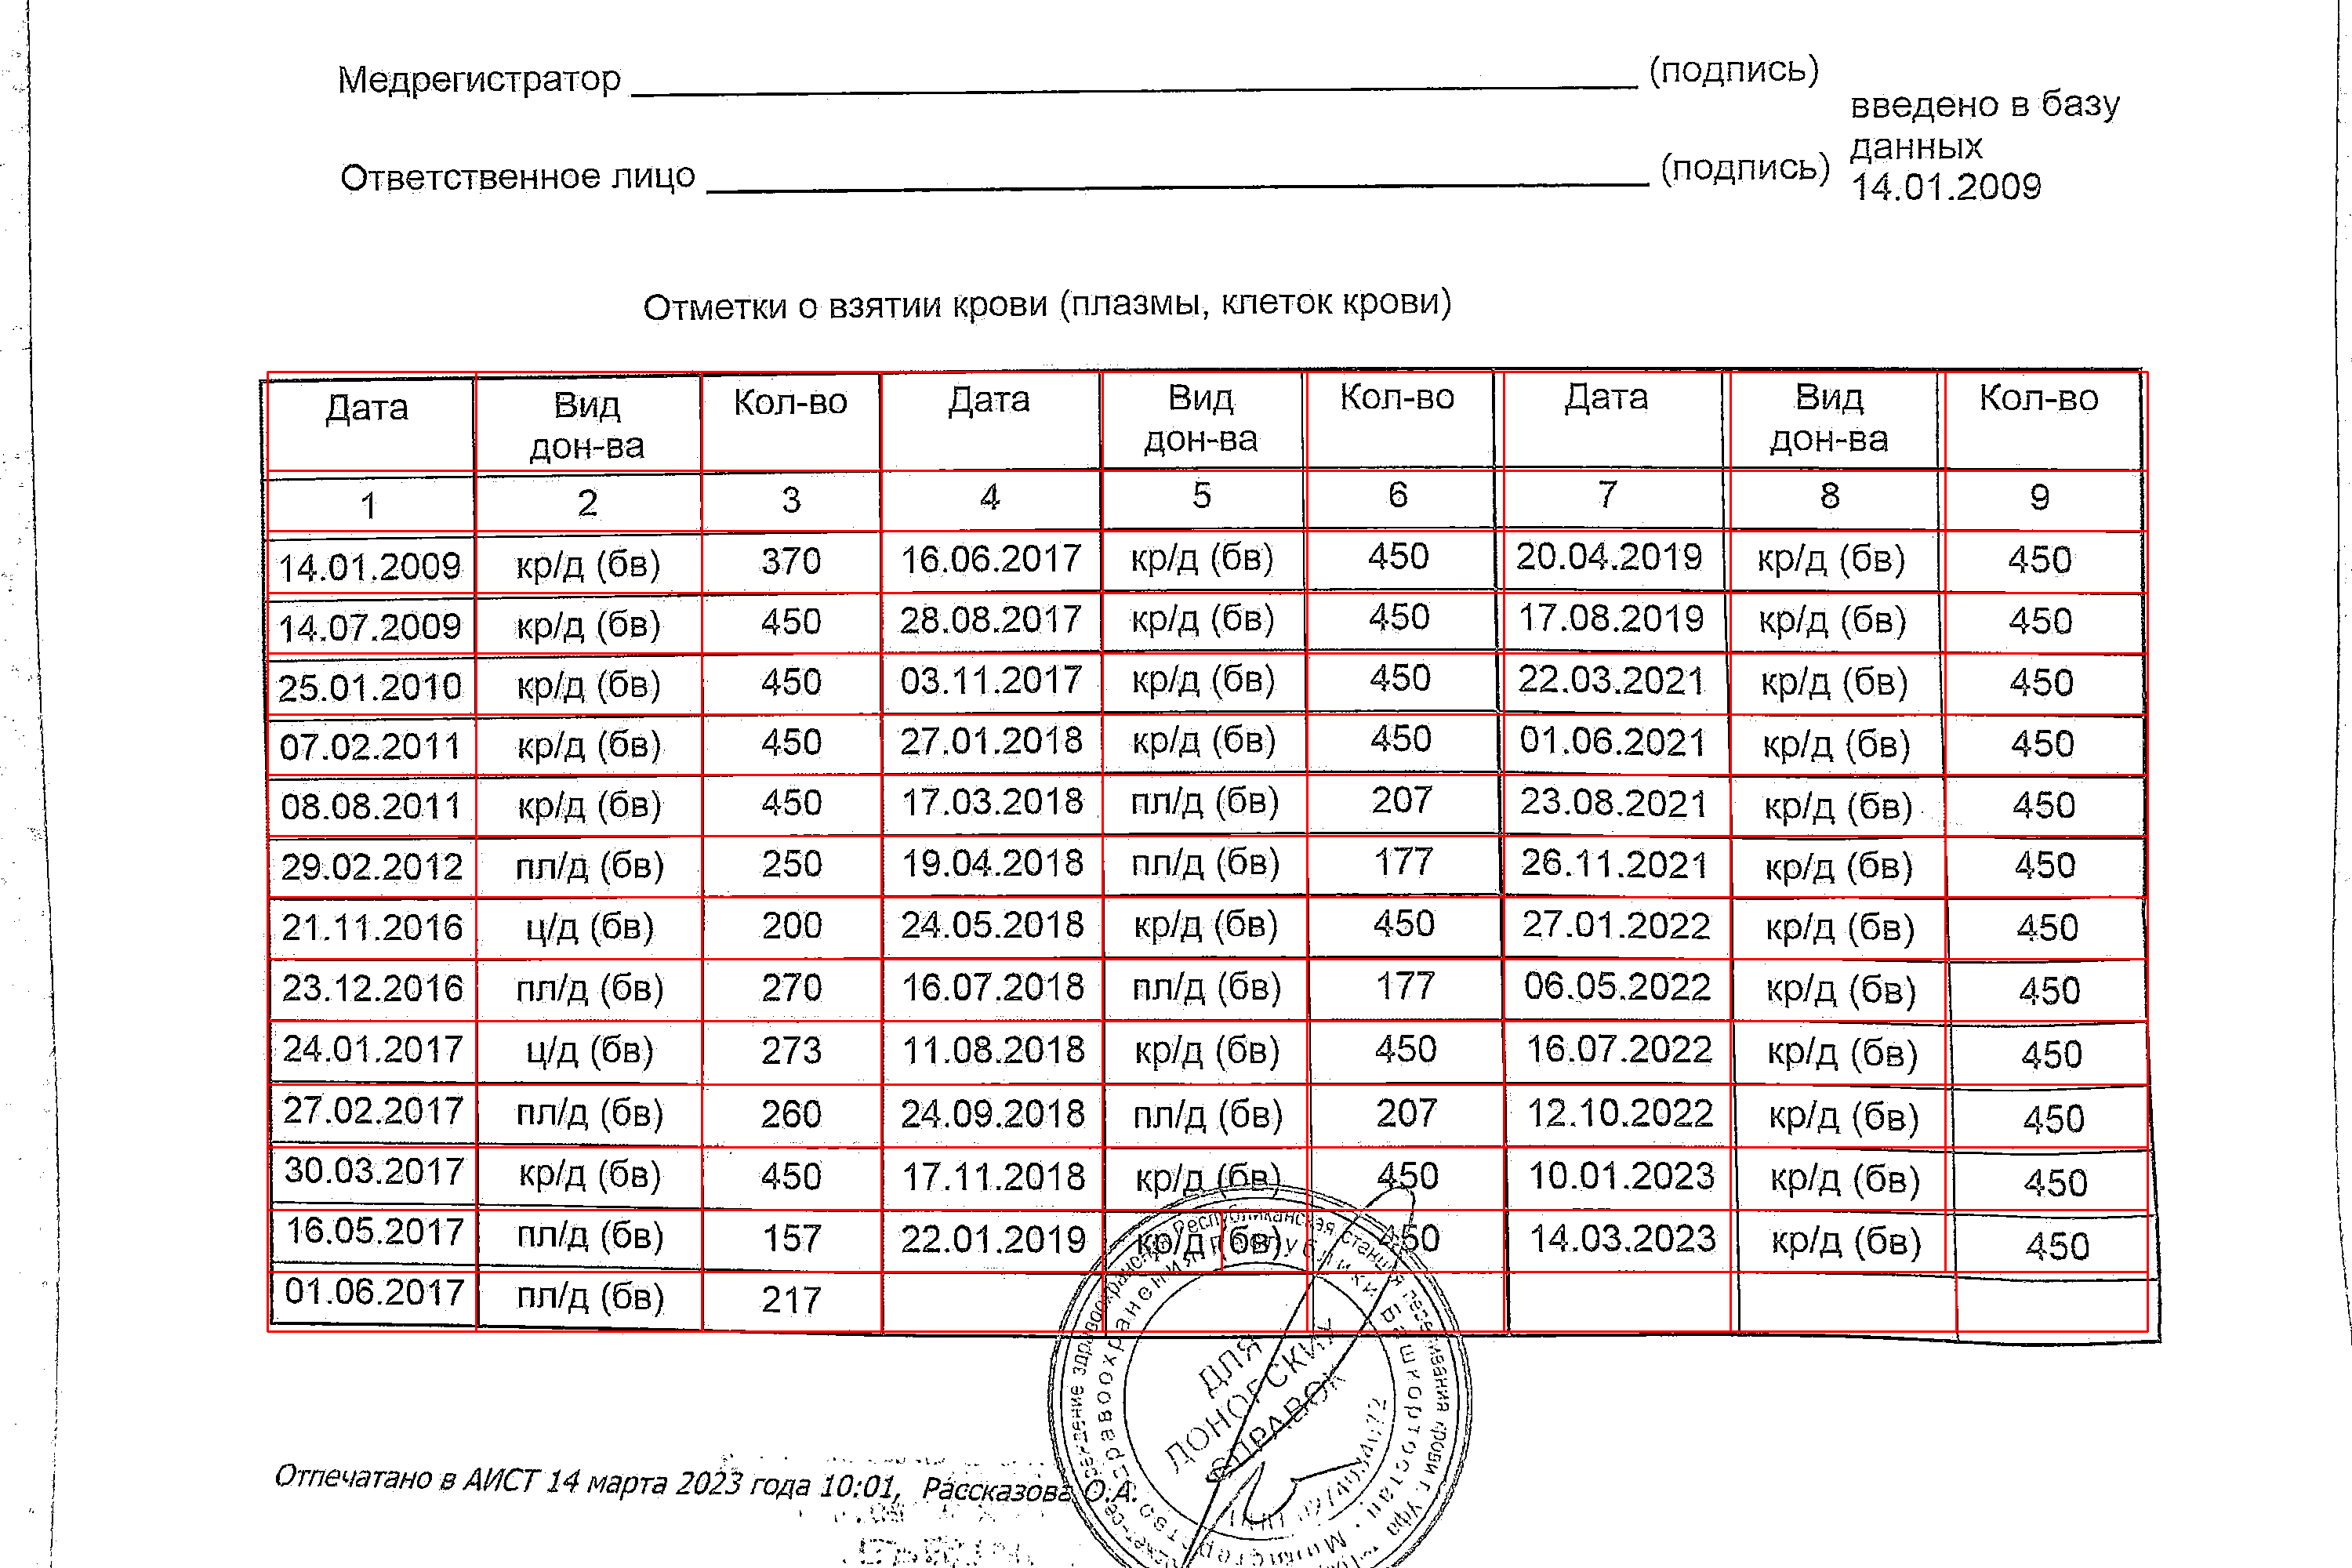

In [8]:
img = Image(src='good.png')

extracted_tables = img.extract_tables()
table_img = (cv2.imread('good.png'))

for table in extracted_tables:
    for row in table.content.values():
        for cell in row:
            cv2.rectangle(table_img, (cell.bbox.x1, cell.bbox.y1), (cell.bbox.x2, cell.bbox.y2), (255, 0, 0), 2)
            
PILImage.fromarray(table_img)

In [17]:
os.environ["TESSDATA_PREFIX"] = "C:/Program Files/Tesseract-OCR/tessdata"

ocr = TesseractOCR(n_threads=1, lang="rus", )


#ocr = EasyOCR(lang=["ru"])

extracted_tables = img.extract_tables(ocr=ocr,
                                      implicit_rows=False,
                                      borderless_tables=False,
                                      min_confidence=50)

OSError: Tesseract not found in environment. Check variables and PATH

In [33]:
string = pytesseract.image_to_string(table_img, lang='rus')
print(string)

Медрегистратор (подпись)

введено в базу

данных
Ответственное лицо (ПОДПИСЬ) чи 01 2009

Отметки о взятии крови (плазмы, клеток крови)

Дата лее | 99 Вид Кол-во Дата кои Вид Кол-во | | Дата Вид
а ва о — ва в ва

Коп-во

во |
И ЕЕ а
ОЕ СЕ ЕЕ ЕЕ ЕСИ ИЕ ЕВ
Ботов | 450 [бала [ колбы [450 [2аааиен | «ид(бы [40 —
тоазони | куды 480 _ [27012018 | «ед(65 |480 [6106201 дв) [480
СЕБЕ ИССА
Ратоть цве [20 [нова рвы [тотал во 45 —
112016 или 5 [270 [16072018 | вм (6е) [| 77__[065202 | ке вы) 480 |
РЕ гот 65 |273 |‘Чебвзолв | иб6ы) | 450 | 16072022 | був) 480 |
[27022517 | плд(65) |280 _ 24баютв пл (65) | 207_ [1210-2622 | уд6а) | 450 |
Пе ао 4 [об чвы —
токва от —

Бо [ебля | ды | 40 |
101.06.2017 ОР И

И

Ч ВОНИ О ПО]

ри

‘е.-,-
. ии
Хе
(> .
< . 21
<:

“та

У

р. 5 \
\,
ЧА

О.А; Е
$ с ^
5, ы .
м < Ио А
Тори


